Tarea 1

accuracy:  0.9652432969215492
precision:  0.9659286447233404
f1:  0.9652411031721377


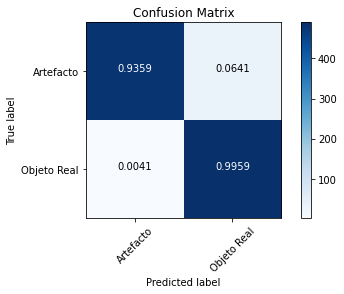

<Figure size 576x216 with 0 Axes>

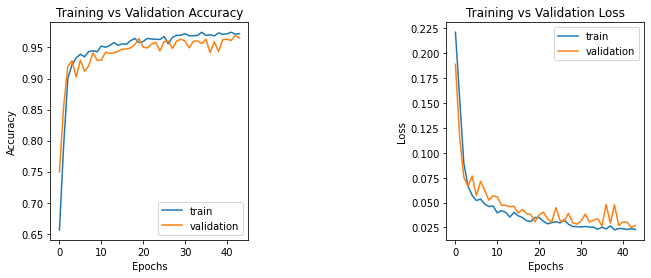

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import itertools
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, Dropout
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score

#obtener data de train y test
data = np.load("/content/drive/MyDrive/data_train.pkl",allow_pickle=True, encoding="latin1")
test_data = np.load("/content/drive/MyDrive/unlab_test.pkl", allow_pickle=True, encoding="latin1")
#Obtención de datos imágenes de train y test
x1_train = data['sci_images']
x1_test = test_data['sci_images']
x2_train = data['temp_images']
x2_test = test_data['temp_images']
x3_train = data['diff_images']
x3_test = test_data['diff_images']
x4_train = data['SNR_images']
x4_test = test_data['SNR_images']
x1_train = x1_train.reshape(-1,21,21,1)
x1_test = x1_test.reshape(-1,21,21,1)
x2_train = x2_train.reshape(-1,21,21,1)
x2_test = x2_test.reshape(-1,21,21,1)
x3_train = x3_train.reshape(-1,21,21,1)
x3_test = x3_test.reshape(-1,21,21,1)
x4_train = x4_train.reshape(-1,21,21,1)
x4_test = x4_test.reshape(-1,21,21,1)

x_all_train = np.concatenate([x1_train,x2_train,x3_train,x4_train], axis=3)
x_all_test = np.concatenate([x1_test,x2_test,x3_test,x4_test], axis=3)
#Normalizar los datos
x_all_train /=255
x_all_test /=255
#reshape a (21,21,4) (4 canales con cada uno es una imágen de 21x21)
x_all_train = x_all_train.reshape(-1,21,21,4)
x_all_test = x_all_test.reshape(-1,21,21,4)

#Obtención de las etiquetas de artefacto o real
y = data['labels'].reshape(-1,1)
ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(y)

##Split de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x_all_train, y, test_size=0.25)

#Modelo CNN de 3 capas convolucionales con 32 filtros de 2x2,3 max pooling de 2x2
#3 Dropouts de 25% y 2 capas densas (una con Dropout de 25%)
modeloco = Sequential()
modeloco.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(21,21,4)))
modeloco.add(MaxPooling2D(pool_size=(2,2)))
modeloco.add(Dropout(0.25))
modeloco.add(Conv2D(filters=32, kernel_size=(2,2)))
modeloco.add(MaxPooling2D(pool_size=(2,2)))
modeloco.add(Dropout(0.25))
modeloco.add(Conv2D(filters=32, kernel_size=(2,2)))
modeloco.add(MaxPooling2D(pool_size=(2,2)))
modeloco.add(Dropout(0.25))
modeloco.add(Flatten())
modeloco.add(Dense(units=32,activation='relu'))
modeloco.add(Dropout(0.25))
modeloco.add(Dense(units=2,activation='softmax'))
#modeloco.summary()
modeloco.compile(optimizer="adam", loss="mse", metrics = ["accuracy"])
modeloco_history = modeloco.fit(x = x_train, y = y_train, batch_size = 45, epochs = 100, validation_data = (x_val, y_val), verbose=False, callbacks=[EarlyStopping( monitor='loss', patience=5)])

#función para imprimir la matríz de confusión
def plot_confusion_matrix(cm,classes,normalize=False,title="Confusion_matrix",cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation="nearest",cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm=cm.astype("float") / cm.sum(axis=1)[:,np.newaxis]
    cm = cm.round(decimals=4)

  thresh = cm.max() /2.
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
                    horizontalalignment="center",
                    color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.savefig("matrix.png")

##predicción de validación
y_test = modeloco.predict(x_val)
y_test = np.argmax(y_test,axis=1)
y_pred = y_val
y_pred = np.argmax(y_pred,axis=1)
#score entre predicciones y datos de validación
print("accuracy: ", accuracy_score (y_test, y_pred))
print("precision: ", precision_score (y_test, y_pred, average = 'macro'))
print("f1: ", f1_score (y_test, y_pred, average = 'macro'))

#predicción de datos de test
y_test = modeloco.predict(x_all_test)
y_test = np.argmax(y_test,axis=1)
#save predictions
predictions = {'ID': test_data['ID'], 'predicted':y_test}
df_out = pd.DataFrame(predictions)
df_out.to_csv ("/content/drive/MyDrive/modeloco_predictions.csv",index=False)
df_out.head()

#score obtenido por modeloco_predictions.csv
#accuracy:  0.975
#precision:  0.9756107819691635
#recall:  0.9749315989055825
#f1:  0.9749889701358299

#confusion matrix
cm_plot_labels = ["Artefacto","Objeto Real"]
cm = confusion_matrix(y_true=y_pred,y_pred=y_test)
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,normalize=True, title="Confusion Matrix")

##Gráfico de accuracy y loss para datos de validación y train
plt.figure(figsize=(8,3))
fig, axs =plt.subplots(1,2)
plt.subplots_adjust(wspace=1, right=1.5)
#accuracy plot
axs[0].plot(modeloco_history.history['accuracy'])
axs[0].plot(modeloco_history.history['val_accuracy'])
axs[0].set(xlabel='Epochs', ylabel='Accuracy')
axs[0].set_title('Training vs Validation Accuracy')
axs[0].legend(['train', 'validation'])
#loss plot 
axs[1].plot(modeloco_history.history['loss'])
axs[1].plot(modeloco_history.history['val_loss'])
axs[1].set(xlabel='Epochs', ylabel='Loss')
axs[1].set_title('Training vs Validation Loss')
axs[1].legend(['train', 'validation'])
